In [1]:
import os
import cPickle
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import hamming_loss, make_scorer, classification_report
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import nltk.data
from nltk.corpus import stopwords

%matplotlib inline
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\Windows\ServiceProfile
[nltk_data]     s\LocalService\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# extract from the IMDB data with only genres and plot
imdb_file_name = 'data/plot.pickle'
# full TMDB data
tmdb_file_name = 'data/tmdb_info.pickle'

In [3]:
def load_part(file_name):
    with open(file_name, 'rb') as handle:
        return cPickle.load(handle)

In [4]:
# load the IMDB extract
imdb_dict = load_part(imdb_file_name)

In [5]:
# load TMDB 
tmdb_dict = load_part(tmdb_file_name)

In [6]:
# add 'overview' from TMDB to 'plot' from IMDB (it is a list)
for tmdb_id, imdb_movie in imdb_dict.iteritems():
    if(
        'plot' in imdb_movie and 
        tmdb_id in tmdb_dict and 
        'overview' in tmdb_dict[tmdb_id].__dict__ and
        tmdb_dict[tmdb_id].__dict__['overview'] is not None):
            imdb_movie['plot'].append(tmdb_dict[tmdb_id].__dict__['overview'])

Prepare the labels

In [7]:
# array of list of genres for every movie
labels = np.array([d['genres'] for d in imdb_dict.values() if 'genres' in d and 'plot' in d ])

In [8]:
# create the labels vector
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(labels)
print 'label matrix shape:', y.shape

label matrix shape: (37668L, 28L)


In [9]:
# number of movies for every genre
label_df = pd.DataFrame(mlb.fit_transform(labels))
label_df.columns = mlb.classes_
label_number_df = pd.DataFrame({'cnt' : label_df.sum(axis = 0)})
label_number_df

,cnt
Action,4318
Adult,158
Adventure,2854
Animation,2420
Biography,1404
Comedy,10693
Crime,3766
Documentary,4480
Drama,16567
Family,2738


Limit the number of genres for performance reasons. OneVsRestClassifier fits as many models as labels.

In [10]:
# only leave generes mentioned in 2000 movies or more
cutoff = 2000
major_genres = set(label_number_df[label_number_df['cnt']  > cutoff].index)
major_genres

{u'Action',
 u'Adventure',
 u'Animation',
 u'Comedy',
 u'Crime',
 u'Documentary',
 u'Drama',
 u'Family',
 u'Fantasy',
 u'Horror',
 u'Mystery',
 u'Romance',
 u'Sci-Fi',
 u'Short',
 u'Thriller'}

In [11]:
# find labels only for the major genres
labels = np.array(
    [major_genres.intersection(d['genres']) for d in imdb_dict.values() if 'genres' in d and 'plot' in d ])

In [12]:
# create the labels vector with only major genres
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(labels)
print 'label matrix shape:', y.shape

label matrix shape: (37668L, 15L)


Prepare the features

In [13]:
# sometimes the plot consists of a few parts, join them together
features = np.array([ ''.join(d['plot']) for d in imdb_dict.values() if 'genres' in d and 'plot' in d ])

Convert a collection of text documents to a matrix of token counts

In [14]:
# convert into bag of words
vectorizer = CountVectorizer( 
    stop_words = stopwords.words("english"), 
    token_pattern = '[a-zA-Z]+[0-9]*',
    max_df = 0.9, 
    min_df = 5, 
    dtype=np.float32 )
X = vectorizer.fit_transform(features)
print 'predictor matrix shape:', X.shape

predictor matrix shape: (37668, 26581)


The goal of using tf-idf instead of the raw frequencies of occurrence of a token in a given document is to scale down the impact of tokens that occur very frequently in a given corpus and that are hence empirically less informative than features that occur in a small fraction of the training corpus.

In [15]:
tt = TfidfTransformer()
X = tt.fit_transform(X)
print 'predictor matrix shape:', X.shape

predictor matrix shape: (37668, 26581)


In [16]:
# get 10% of the observations in the test set, that is our working set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# use the working set to create test / train data
X_train, X_test, y_train, y_test = train_test_split(X_test, y_test, test_size=0.25, random_state=42)

print 'Train label matrix shape:', y_train.shape
print 'Train predictor matrix shape:', X_train.shape
print 'Test label matrix shape:', y_test.shape
print 'Test predictor matrix shape:', X_test.shape

Train label matrix shape: (5650L, 15L)
Train predictor matrix shape: (5650, 26581)
Test label matrix shape: (1884L, 15L)
Test predictor matrix shape: (1884, 26581)


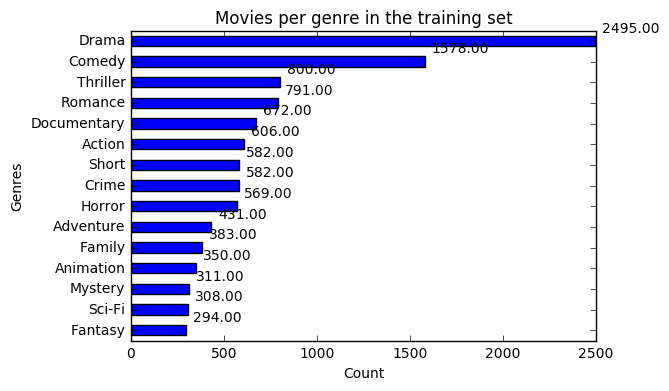

In [17]:
label_df = pd.DataFrame(y_train)
label_df.columns = mlb.classes_
label_number_df = pd.DataFrame({'cnt' : label_df.sum(axis = 0)})
ax = label_number_df.sort_values('cnt')['cnt'].plot(kind="barh", title = 'Movies per genre in the training set')
for p in ax.patches:
    ax.annotate(
        "%.2f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y()), xytext=(5, 10), textcoords='offset points')
plt.xlabel('Count')
plt.ylabel('Genres')

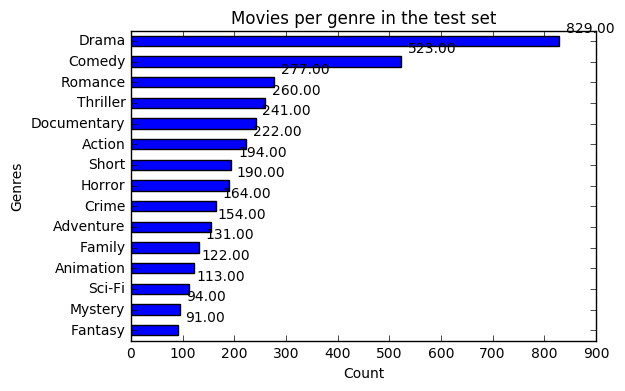

In [18]:
label_df = pd.DataFrame(y_test)
label_df.columns = mlb.classes_
label_number_df = pd.DataFrame({'cnt' : label_df.sum(axis = 0)})
ax = label_number_df.sort_values('cnt')['cnt'].plot(kind="barh", title = 'Movies per genre in the test set')
for p in ax.patches:
    ax.annotate(
        "%.2f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y()), xytext=(5, 10), textcoords='offset points')
plt.xlabel('Count')
plt.ylabel('Genres')

The Hamming loss is the fraction of labels that are incorrectly predicted.

In [19]:
param_grid = {
    'estimator__loss': ('hinge', 'log', 'perceptron'),
    'estimator__alpha' : (0.1, 0.01, 0.0001),
    'estimator__penalty' : ('l1', 'l2', 'elasticnet')}

model = OneVsRestClassifier(SGDClassifier(
        random_state = 322,
        loss = 'hinge',
        alpha = 0.00001,
        penalty = 'elasticnet'
    ))

model_tunning = GridSearchCV(
    model, 
    param_grid = param_grid, 
    scoring = make_scorer(hamming_loss, greater_is_better = False), 
    n_jobs = 7, 
    verbose = 10)

model_tunning.fit(X, y)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=7)]: Done   4 tasks      | elapsed:   13.3s
[Parallel(n_jobs=7)]: Done  11 tasks      | elapsed:   26.9s
[Parallel(n_jobs=7)]: Done  18 tasks      | elapsed:   40.1s
[Parallel(n_jobs=7)]: Done  27 tasks      | elapsed:   55.7s
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:  1.2min
[Parallel(n_jobs=7)]: Done  47 tasks      | elapsed:  1.4min
[Parallel(n_jobs=7)]: Done  58 tasks      | elapsed:  1.7min
[Parallel(n_jobs=7)]: Done  77 out of  81 | elapsed:  2.3min remaining:    6.9s
[Parallel(n_jobs=7)]: Done  81 out of  81 | elapsed:  2.3min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=OneVsRestClassifier(estimator=SGDClassifier(alpha=1e-05, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='elasticnet', power_t=0.5, random_state=322, shuffle=True,
       verbose=0, warm_start=False),
          n_jobs=1),
       fit_params={}, iid=True, n_jobs=7,
       param_grid={'estimator__alpha': (0.1, 0.01, 0.0001), 'estimator__penalty': ('l1', 'l2', 'elasticnet'), 'estimator__loss': ('hinge', 'log', 'perceptron')},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(hamming_loss, greater_is_better=False),
       verbose=10)

Classification quility on the training set

In [20]:
print classification_report(y_train, model_tunning.predict(X_train))

             precision    recall  f1-score   support

          0       0.94      0.19      0.32       606
          1       1.00      0.02      0.04       431
          2       0.97      0.25      0.39       350
          3       0.92      0.41      0.57      1578
          4       0.93      0.19      0.32       582
          5       0.94      0.66      0.78       672
          6       0.80      0.76      0.78      2495
          7       0.95      0.16      0.28       383
          8       1.00      0.03      0.06       294
          9       0.96      0.41      0.57       569
         10       1.00      0.01      0.03       311
         11       0.89      0.09      0.16       791
         12       0.94      0.30      0.46       308
         13       0.96      0.16      0.27       582
         14       0.95      0.08      0.15       800

avg / total       0.91      0.37      0.46     10752



Classification quility on the test set

In [21]:
print classification_report(y_test, model_tunning.predict(X_test))

             precision    recall  f1-score   support

          0       0.96      0.12      0.21       222
          1       0.88      0.05      0.09       154
          2       0.97      0.28      0.43       122
          3       0.93      0.42      0.58       523
          4       0.81      0.18      0.29       164
          5       0.94      0.63      0.75       241
          6       0.81      0.75      0.78       829
          7       1.00      0.15      0.25       131
          8       1.00      0.05      0.10        91
          9       0.92      0.48      0.63       190
         10       0.00      0.00      0.00        94
         11       0.87      0.10      0.18       277
         12       0.95      0.34      0.50       113
         13       0.97      0.20      0.33       194
         14       0.63      0.07      0.12       260

avg / total       0.85      0.37      0.46      3605



C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
